# Hurricane Tracker Example in R

This demo uses the excellent [rrricanes](https://ropensci.org/blog/2017/09/27/rrricanes/) package to load and analyze data from the [National Hurricane Center](https://www.nhc.noaa.gov/). We present an abridged
walk-through of the tutorial at the former link, using sample data from 2018,
just as hurricane season is starting.

Comments/corrections to hsnyder@cocalc.com.

*Note: running this notebook requires a project with internet access.*

## Preparation

Before this worksheet can be run, some files need to be installed in your project. We expect these preparatory steps will not be necessary after pending CoCalc system updates are completed. The software request for system updates for `rrricanes` and dependencies
is tracked on GitHub under CoCalc [issue 2922](https://github.com/sagemathinc/cocalc/issues/2922).

### Update GDAL - Geospatial Data Abstraction Library

We need an up-to-date version of [GDAL](http://www.gdal.org/). In a .term, do

```
~$ wget http://download.osgeo.org/gdal/2.3.0/gdal-2.3.0.tar.xz
~$ tar -xf gdal-2.3.0.tar.xz
~$ cd gdal-2.3.0/
~$ ./configure --prefix=/home/user/opt
~$ make # this step can take up to an hour
~$ make install
~$ export LD_LIBRARY_PATH="/home/user/opt/lib"
~$ R
> withr::with_makevars(c(PKG_CONFIG_PATH="/home/user/opt/lib/pkgconfig",
  LD_LIBRARY_PATH="/home/user/opt/lib"),
  install.packages("rgdal",verbose=TRUE,
  lib="/home/user/R/x86_64-pc-linux-gnu-library/3.4"),
  assignment="+=")
```

### Install R packages for Hurricane Data

In a .term, do the one **Installation** and the two **Optional Supporting Packages** steps at the [tutorial](https://ropensci.org/blog/2017/09/27/rrricanes/). When you install packages with R inside a project, they are stored under your home directory, for example: `/home/user/R/x86_64-pc-linux-gnu-library/3.4`

```
~$ R
> devtools::install_github("ropensci/rrricanes", build_vignettes = TRUE)
> install.packages("rrricanesdata",
                 repos = "https://timtrice.github.io/drat/",
                 type = "source")
> install.packages("rnaturalearthhires",
                 repos = "http://packages.ropensci.org",
                 type = "source")
```


In [1]:
library(dplyr)
library(rrricanes)
get_storms() %>% print(n = nrow(.))


Attaching package: ‘dplyr’



The following objects are masked from ‘package:stats’:

    filter, lag



The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



rrricanes is not intended for use in emergency situations.


# A tibble: 5 x 4
   Year Name                      Basin Link                                   
  <dbl> <chr>                     <chr> <chr>                                  
1  2018 Subtropical Storm Alberto AL    http://www.nhc.noaa.gov/archive/2018/A…
2  2018 Tropical Depression One-E EP    http://www.nhc.noaa.gov/archive/2018/O…
3  2018 Hurricane Aletta          EP    http://www.nhc.noaa.gov/archive/2018/A…
4  2018 Hurricane Bud             EP    http://www.nhc.noaa.gov/archive/2018/B…
5  2018 Tropical Storm Carlotta   EP    http://www.nhc.noaa.gov/archive/2018/C…


In [3]:
# look at Subtropical Storm Alberto from May, 2018
ds <- get_storms() %>%
  filter(Name == "Subtropical Storm Alberto") %>%
  pull(Link) %>%
  get_storm_data(products = c("discus", "fstadv"))

In [4]:
key <- ds$fstadv %>% pull(Key) %>% first()
key

'AL012018'

In [6]:
dyn.load("/home/user/opt/lib/libgdal.so")

In [7]:
# make sure we are using the correct library version
library(rgdal)

rgdal: version: 1.3-2, (SVN revision 755)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.3.0, released 2018/05/04
 Path to GDAL shared files: /home/user/opt/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


In [8]:
gis <- gis_advisory(key = key, advisory = "5A") %>%
  gis_download()

OGR data source with driver: ESRI Shapefile 
Source: "/tmp/Rtmp2BzAbO", layer: "al012018-005A_5day_lin"
with 1 features
It has 7 fields
OGR data source with driver: ESRI Shapefile 
Source: "/tmp/Rtmp2BzAbO", layer: "al012018-005A_5day_pgn"
with 1 features
It has 7 fields
OGR data source with driver: ESRI Shapefile 
Source: "/tmp/Rtmp2BzAbO", layer: "al012018-005A_5day_pts"
with 8 features
It has 23 fields
OGR data source with driver: ESRI Shapefile 
Source: "/tmp/Rtmp2BzAbO", layer: "al012018-005A_ww_wwlin"
with 6 features
It has 8 fields


In [9]:
names(gis)

'al012018_005A_5day_lin' 
 'al012018_005A_5day_pgn' 
 'al012018_005A_5day_pts' 
 'al012018_005A_ww_wwlin'

Regions defined for each Polygons


Regions defined for each Polygons


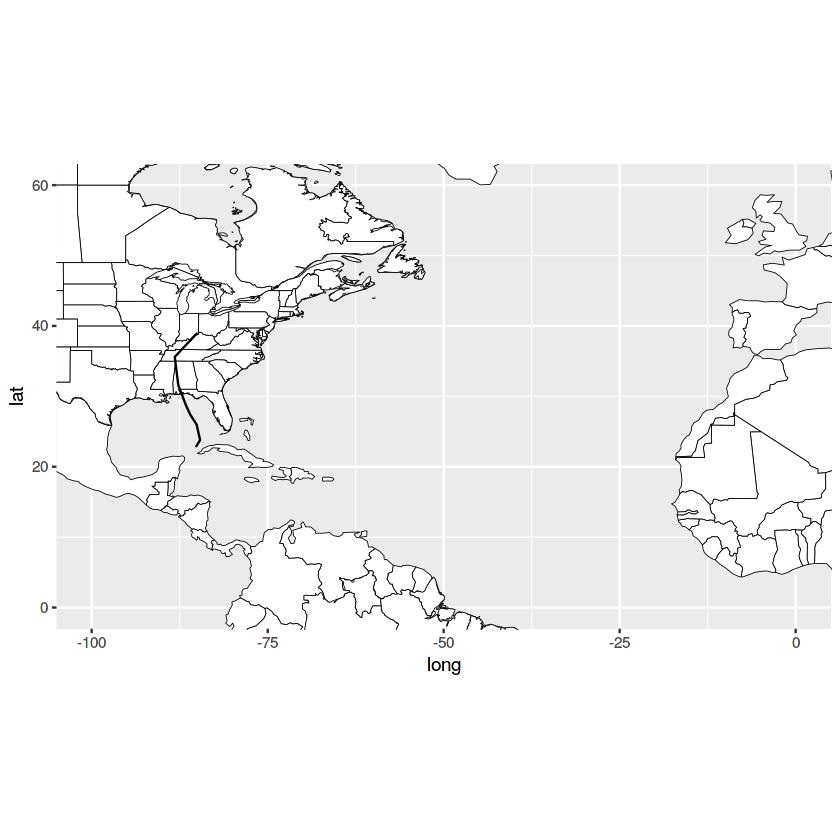

In [14]:
library(ggplot2)
al_tracking_chart(color = "black", size = 0.18, fill = "white") +
  geom_path(data = shp_to_df(gis$al012018_005A_5day_lin), aes(x = long, y = lat))

In [15]:
sp::bbox(gis$al012018_005A_5day_lin)

min max 
 
 x -88.2 -84.6 
 y 22.8 39.0

In [16]:
sp::bbox(gis$al012018_005A_5day_pgn)

min max 
 
 x -91.27861 -80.76614 
 y 22.47396 42.28889

Regions defined for each Polygons


Regions defined for each Polygons


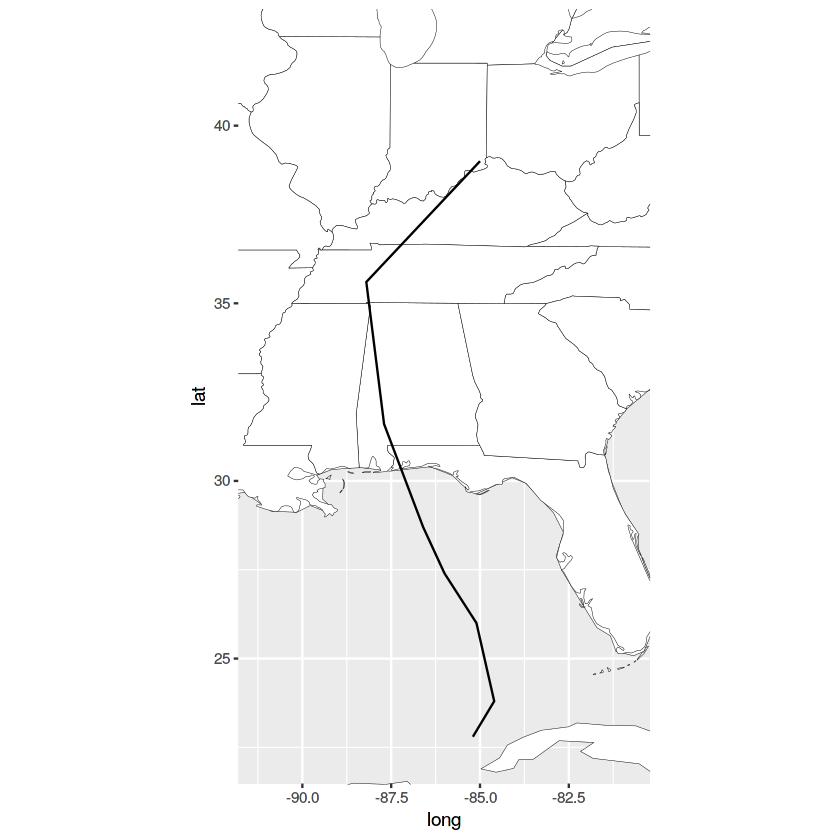

In [17]:
bb <- sp::bbox(gis$al012018_005A_5day_pgn)
al_tracking_chart(color = "black", size = 0.1, fill = "white") +
  geom_path(data = shp_to_df(gis$al012018_005A_5day_lin),
            aes(x = long, y = lat)) +
  coord_equal(xlim = c(bb[1,1], bb[1,2]),
              ylim = c(bb[2,1], bb[2,2]))

In [18]:
bp <- al_tracking_chart(color = "black", size = 0.1, fill = "white") +
  coord_equal(xlim = c(bb[1,1], bb[1,2]),
              ylim = c(bb[2,1], bb[2,2]))

Regions defined for each Polygons


Regions defined for each Polygons


In [19]:
names(gis$al012018_005A_5day_pts)

'ADVDATE' 
 'ADVISNUM' 
 'BASIN' 
 'DATELBL' 
 'DVLBL' 
 'FCSTPRD' 
 'FLDATELBL' 
 'GUST' 
 'LAT' 
 'LON' 
 'MAXWIND' 
 'MSLP' 
 'SSNUM' 
 'STORMNAME' 
 'STORMNUM' 
 'STORMSRC' 
 'STORMTYPE' 
 'TCDVLP' 
 'TAU' 
 'TCDIR' 
 'TCSPD' 
 'TIMEZONE' 
 'VALIDTIME'

In [20]:
# which forecast ranges, i.e. 60-day, 120-day, are available in the data?
table(gis$al012018_005A_5day_pts$FCSTPRD)


120 
  8 

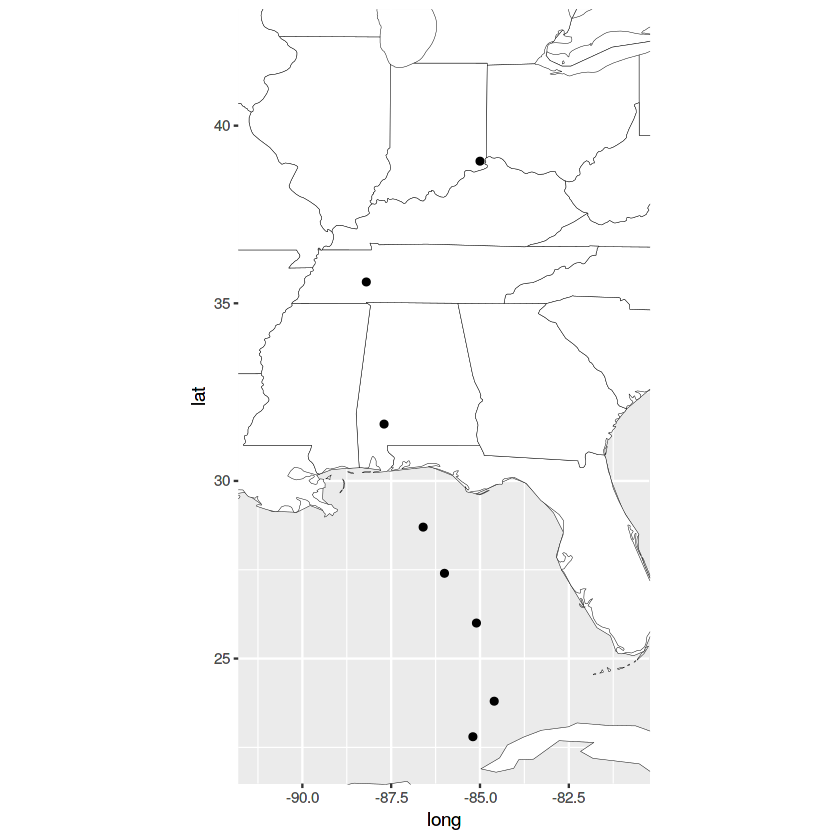

In [21]:
bp +
  geom_point(data = tibble::as_data_frame(gis$al012018_005A_5day_pts),
             aes(x = LON, y = LAT))

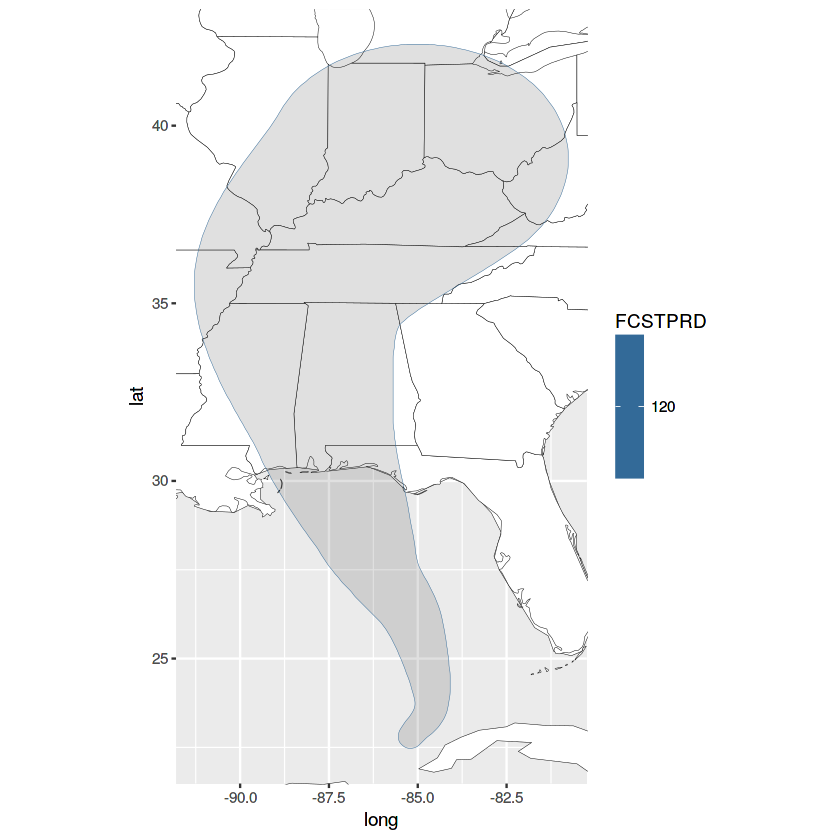

In [22]:
bp +
  geom_polygon(data = shp_to_df(gis$al012018_005A_5day_pgn) %>%
                 filter(FCSTPRD == 120),
               aes(x = long, y = lat, color = FCSTPRD), alpha=0.15, size=0.1)